In [1]:
# install pytorch
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# show what we got
!pip list

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
ale-py                        0.7.4
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
AutoROM                       0.4.2
AutoROM.accept-rom-license   

In [2]:
# install stable-baslines (implementations of reinforcement learning algorithms in PyTorch)
!pip install stable-baselines3[extra] protobuf==3.20.*

In [3]:
# install pydirectinput for input handaling
!pip install pydirectinput

In [4]:
# install pytesseract for OCR
!pip install pytesseract

In [5]:
# instal mss for image capture
!pip install mss

In [17]:
# file path
import os
# screen capture
from mss import mss
# command sending 
import pydirectinput
# fram proccesing
import cv2
# transformatinoal framework
import numpy as np
# OCR for game extraction
import pytesseract
# visualize captures
from matplotlib import pyplot as plt
# pause time
import time
# env componenet
from gym import Env
# box for the image, descrete for possible actions
from gym.spaces import Box, Discrete
# saving models
from stable_baselines3.common.callbacks import BaseCallback
# check env
from stable_baselines3.common import env_checker
# get DQN algorithm
from stable_baselines3 import DQN

In [18]:
 # set tessoract locations
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [26]:

class game(Env):
    # set env action and obser shaps
    def __init__(self):
        # use the base class
        super().__init__()
        # setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # def extraction parameters
        self.cap = mss()
        self.game_location = {'top':200, 'left':500, 'width':400, 'height':400}
        self.done_location = {'top':405, 'left':800, 'width':330, 'height':80}
        
    # called to do somehitng in the game     
    def step(self, action):
        # actions: 0 - space(jump), 1 - down(duck), 2 - no action(no op) 
        action_map = {0: 'up', 1: 'down', 2: 'no_op'}
    
        # simulate press if not no_op
        if action != 2:
            pydirectinput.press(action_map[action])
    
        # check for gameover
        done, done_cap = self.get_done()
        # check next observ
        new_observ = self.get_observation()
        # reward - get point for each frame that isn't gameover
        reward = 1
        #info dic
        info = {}
        return new_observ, reward, done, info 
    # vusualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    # closes the done observ
    def close(self):
        cv2.destroyAllWindows()
    # restart the game     
    def reset(self):
        time.sleep(1)
        pydirectinput.press('up')
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        time.sleep(2)
        return self.get_observation()

    # get a part of the observation that we want
    def get_observation(self):
        # get screen capture (only first 3 cahnnels) and extract the values from it
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # resize
        resized = cv2.resize(gray, (100,83))
        # add channels first 
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    # get done part of the observation
    def get_done_obsevarion(self):
        raw = np.array(self.cap.grab(self.done_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel 
    
    # get the done text with OCR
    def get_done(self):
        # get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
        done_str = ['GAME','GAHE']
        
        # Apply OCR
        # flag to recognize gameover
        done = False
        # get string
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_str:
            # found gameover
            done = True
        # return game status
        return done, done_cap

In [27]:
env = game()

In [21]:
done, done_cap = env.get_done()

In [22]:
done

False

In [12]:
env.render()

In [13]:
env.close()

In [23]:
# observ values
env.get_observation()

array([[[247, 247, 247, ..., 177, 149, 237],
        [247, 247, 247, ..., 248, 248, 248],
        [247, 247, 247, ..., 247, 247, 247],
        ...,
        [247, 247, 247, ..., 247, 247, 202],
        [247, 247, 247, ..., 228, 243, 247],
        [247, 247, 247, ..., 247, 247, 247]]], dtype=uint8)

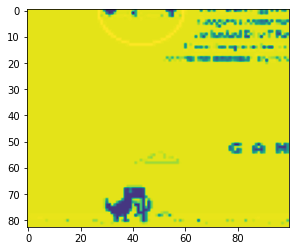

In [24]:
# observ after proccecing
plt.imshow(env.get_observation()[0])

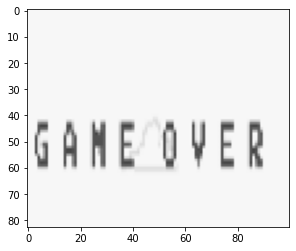

In [28]:
plt.imshow(cv2.cvtColor(env.get_done_obsevarion()[0], cv2.COLOR_BGR2RGB))

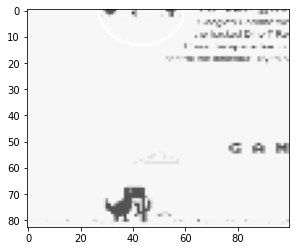

In [29]:
# observ after proccecing it back to the original
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [31]:
# play 10 games
for ep in range(3):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'total reward for ep {ep} is {total_reward}')

total reward for ep 0 is 6
total reward for ep 1 is 5
total reward for ep 2 is 6


In [13]:
# check that env is ok
env_checker.check_env(env)

In [15]:
# def callbacks for saving models
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [16]:
# set DIRs
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [17]:
# set our call back
callback = TrainAndLoggingCallback(check_freq=300, save_path=CHECKPOINT_DIR)

In [17]:
# create DQN model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
            buffer_size= 150000, learning_starts= 100)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
# training
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 28       |
|    total_timesteps  | 23       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 53       |
|    total_timesteps  | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.92     |
|    ep_rew_mean      | 5.92     |
|    exploration_rate | 0.326    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.22     |
|    ep_rew_mean      | 5.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 72       |
|    fps              | 0        |
|    time_elapsed     | 437      |
|    total_timesteps  | 376      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.72e-05 |
|    n_updates        | 68       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18     |
|    ep_rew_mean      | 5.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 76       |
|    fps              | 0        |
|    time_elapsed     | 461      |
|    total_timesteps  | 394      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000268 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.97     |
|    ep_rew_mean      | 4.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 136      |
|    fps              | 0        |
|    time_elapsed     | 820      |
|    total_timesteps  | 688      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.89e-05 |
|    n_updates        | 146      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.92     |
|    ep_rew_mean      | 4.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 140      |
|    fps              | 0        |
|    time_elapsed     | 844      |
|    total_timesteps  | 704      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.28     |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 0        |
|    time_elapsed     | 1198     |
|    total_timesteps  | 954      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2e-05    |
|    n_updates        | 213      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.28     |
|    ep_rew_mean      | 4.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 204      |
|    fps              | 0        |
|    time_elapsed     | 1221     |
|    total_timesteps  | 970      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2e-05    |
|    n_updates      

In [46]:
# test model
for ep in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print(f'total reward for ep {ep} is {total_reward}')
#     time.sleep(2)

total reward for ep 0 is 421
total reward for ep 1 is 10
total reward for ep 2 is 34
total reward for ep 3 is 14
total reward for ep 4 is 12


In [ ]:
# model.load(os.path.join('train_first', 'best_model_900'))